<a href="https://colab.research.google.com/github/SJin765/class_AI4dl/blob/main/Team_project/220530_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/achinih/flower-classification-cnn-models

# Step 1: Imports

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf

# Step 2: Distribution Strategy

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Step 3: Loading the Competition Data

In [ ]:
# GCS에서 데이터를 받아올 경우
# Get GCS Path
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

In [3]:
# 구글 드라이브에 내가 올려놓은 파일을 이용할 경우
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/tpu-getting-started'

Mounted at /content/drive


In [5]:
# Load Data
IMAGE_SIZE = [512, 512]
GCS_PATH =file_path + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [6]:
# Create Data Pipelines

def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [7]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [8]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Training data label examples: [56 67 91 ... 67 14 93]


# Step 4: Explore Data

# Step 5: Define Model : CNN Models

## Defining Baseline Model

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dense, Dropout

EPOCHS = 20

In [10]:
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
gu_seed=tf.keras.initializers.GlorotUniform(seed=1)

EPOCHS = 20
with strategy.scope():
    """pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential(([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ]))"""
    model0 = tf.keras.Sequential()
    model0.add(Conv2D(32, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu', input_shape=(512,512,3)))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Flatten())
    model0.add(Dense(len(CLASSES), activation='softmax'))
    
    
    """
    model2 = tf.keras.Sequential()
    model2.add(Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(512,512,1)))
    model2.add(MaxPool2D(pool_size=(3,3)))
    model2.add(Dropout(0.25))
    
    model2.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
    model2.add(MaxPool2D(pool_size=(3,3)))
    model2.add(Dropout(0.25))
    
    model2.add(Flatten())
    model2.add(Dense(len(CLASSES), activation='softmax'))"""

In [11]:
model0.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 170, 170, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 170, 170, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 170, 170, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

Learning rate schedule: 0.0005 to 0.0005 to 5.43e-05


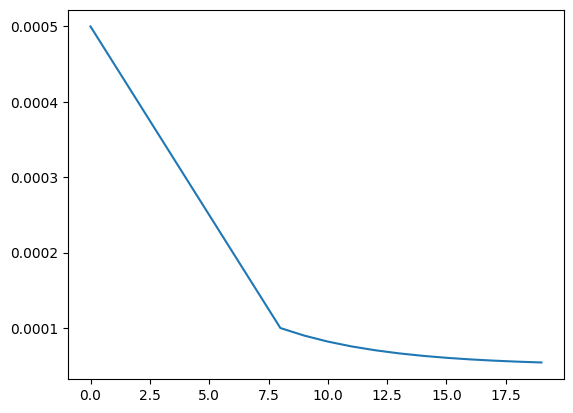

In [15]:
# Define learning rate schedule
from matplotlib import pyplot as plt
def adapt_learning_rate(epoch,
                   start_lr = 0.0005, min_lr = 0.00005, max_lr = 0.0001,
                   rampup_epochs = 8, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [adapt_learning_rate(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model0.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20


## Model Baseline Overview

### Graphs

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model0.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

## ResNet50 (poor accuracy)

### Defining Model

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
gu_seed=tf.keras.initializers.GlorotUniform(seed=1)

EPOCHS = 20
with strategy.scope():
    """pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential(([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ]))"""
    model0 = tf.keras.Sequential()
    model0.add(Conv2D(32, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu', input_shape=(512,512,3)))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Flatten())
    model0.add(Dense(len(CLASSES), activation='softmax'))
    
    
    """
    model2 = tf.keras.Sequential()
    model2.add(Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(512,512,1)))
    model2.add(MaxPool2D(pool_size=(3,3)))
    model2.add(Dropout(0.25))
    
    model2.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
    model2.add(MaxPool2D(pool_size=(3,3)))
    model2.add(Dropout(0.25))
    
    model2.add(Flatten())
    model2.add(Dense(len(CLASSES), activation='softmax'))"""


EPOCHS = 20
with strategy.scope():
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
        
    )
    pretrained_model.trainable = True
    
    modelTwo = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5), 
        
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=gu_seed, padding='same', activation='relu'))
    model0.add(MaxPool2D(pool_size=(3,3)))
    model0.add(Dropout(0.25))
    
    model0.add(Flatten())        
        
        
        
        
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
modelTwo.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

modelTwo.summary()

In [ ]:
def adapt_learning_rate(epoch,
                   start_lr = 0.0005, min_lr = 0.00005, max_lr = 0.0001,
                   rampup_epochs = 8, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [adapt_learning_rate(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = modelTwo.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

One interesting thing to notice is that even though the training accuracy increases significantly from the start, the model is rather slow to adapt to the patterns and learn to generalise to the validation data. This could be due to it taking much longer to change the weights of the ResNet50 model as the model itself should have set weights already.

### Model Overview

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = modelTwo.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

The graphs above with a heavy fluctuation of model validation loss at the start indicates that my initial learning rate may be too high. However as both curves eventually start to move to each other, it is concluded that the network's traning graph is likely to have one big global minima (second image) rather than many local minima (first image). This means that the learning rate shouldn't have too much of an effect on the network and the network's performace is near maximised at 91% accuracy.

## Xception

### Defining Model

In [ ]:
EPOCHS = 20
with strategy.scope():
    pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
        
    )
    pretrained_model.trainable = False
    
    modelThree = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4096, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(512, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
modelThree.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

modelThree.summary()

In [ ]:
def adapt_learning_rate(epoch,
                   start_lr = 0.0005, min_lr = 0.00005, max_lr = 0.0001,
                   rampup_epochs = 6, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [adapt_learning_rate(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = modelThree.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

### Model Overview

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
from sklearn.metrics import confusion_matrix

cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = modelThree.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
import numpy as np

confusion = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)

total = np.sum(confusion)
accuracy = np.trace(confusion) / float(total)
specificity = np.diag(confusion)[0] / np.sum(confusion[0])
sensitivity = np.diag(confusion)[1] / np.sum(confusion[1])
ppv = np.diag(confusion)[1] / np.sum(confusion[:, 1])
npv = np.diag(confusion)[0] / np.sum(confusion[:, 0])

# Print the results
print("Accuracy:", accuracy)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("PPV:", ppv)
print("NPV:", npv)

# Step 7: Evaluate Predictions

# Step 8: Make Test Predictions

# Step 9: Make a submission